# Deep Learning - Exercise 4

This lecture is about advanced topics of the CNN such as transfer learning and 1D convolutions for time-series processing.

We use CIFAR-10 dataset again and [FordA](https://www.timeseriesclassification.com/description.php?Dataset=FordA) for TS classification task.

[Open in Google colab](https://colab.research.google.com/github/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_04.ipynb)
[Download from Github](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_04.ipynb)

##### Remember to set **GPU** runtime in Colab!

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pandas as pd
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # images
import numpy as np #numpy
import tensorflow as tf
import tensorflow.keras as keras
import requests

from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG19

from sklearn.model_selection import train_test_split # split for validation sets
from sklearn.preprocessing import normalize # normalization of the matrix
from scipy.signal import convolve2d # convolutionof the 2D signals
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from PIL import Image
from io import BytesIO
from skimage.transform import resize

import tensorflow_datasets


tensorflow_datasets.disable_progress_bar()

tf.version.VERSION

'2.11.0'

In [2]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

def show_example(train_x, train_y, class_names):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_x[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[train_y[i][0]])
    plt.show()
    
def display_activation(activations, col_size, row_size, act_index):
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            if activation_index < activation.shape[3]-1:
                activation_index += 1
                
def compute_metrics(y_true, y_pred, show_confusion_matrix=False):
    print(f'\tAccuracy: {accuracy_score(y_true, y_pred)*100:8.2f}%')
    if (show_confusion_matrix):
        print('\tConfusion matrix:\n', confusion_matrix(y_true, y_pred))

## 🔎 What is transfer learning? 🔎

* Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem. For instance, features from a model that has learned to identify cars may be useful to kick-start a model meant to identify trucks.
    * 🔎 Do you know any famous CNN models?

* Transfer learning is usually done for tasks where your dataset has too little data to train a full-scale model from scratch.
    * 🔎 Why do we benefit from it?
    
### Usual pipeline

1) Take layers from a previously trained model.

2) Freeze them, so as to avoid destroying any of the information they contain during future training rounds.

3) Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.

4) Train the new layers on your dataset.

* Optional: Fine-tuning = unfreezing the entire model you obtained above (or part of it), and re-training it on the new data with a very low learning rate. This can potentially achieve meaningful improvements, by incrementally adapting the pretrained features to the new data.
    * 🔎 Why do we use small learning rate?


# Let's start

### Import dataset **CIFAR10** again
* The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. 
* The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. 
* There are 6,000 images of each class.

Dataset is:
* downloaded
* splitted into train and test set
* converted from the range <0,255> into <0, 1>
* *train* is splitted into *train* and *validation* set 
* class names are defined

### We will resize the images into (224, 224) shape because we will use ResNet50 later and one-hot encode our labels
* If you do not encode the labels you will run into shape mismatch error which is hard to debug - trust me, I've been there 🙂

In [3]:
# cifar is the basic dataset for image classifaction
dataset = tf.keras.datasets.cifar10
img_size = 224
subset = 1000

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_count = len(class_names)

# data from any dataset are loaded using the load_Data function
(train_x, train_y), (test_x, test_y) = dataset.load_data()

train_y = tf.keras.utils.to_categorical(train_y[:subset], class_count)
test_y = tf.keras.utils.to_categorical(test_y[:subset], class_count)

rs_train_x = resize(train_x[:subset], (len(train_x[:subset]),img_size,img_size,3), preserve_range=True).astype(np.uint8)

del train_x

rs_test_x = resize(test_x[:subset], (len(test_x[:subset]),img_size,img_size,3), preserve_range=True).astype(np.uint8)

del test_x

rs_train_x = rs_train_x/255.0
rs_test_x = rs_test_x/255.0

train_x, valid_x, train_y, valid_y = train_test_split(rs_train_x, train_y, test_size=0.2, random_state=42)
test_x = rs_test_x

# the data are in the form of 32x32 pixes with values 0-255.
print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)


print('Class count:', class_count, class_names)

170498071/170498071 [==============================] - 13s 0us/step
Train data shape:  (800, 224, 224, 3) (800, 10)
Validation data shape:  (200, 224, 224, 3) (200, 10)
Test data shape:   (1000, 224, 224, 3) (1000, 10)
Class count: 10 ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


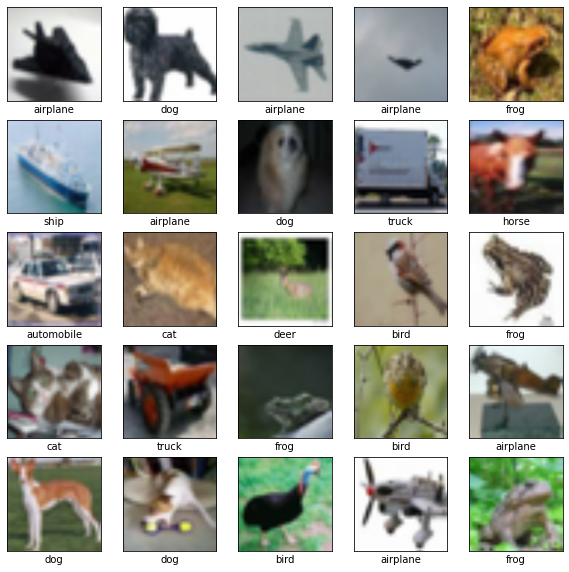

In [4]:
show_example(train_x, np.argmax(train_y, axis=1).reshape(-1, 1), class_names)

## First, instantiate a base model with pre-trained weights.
* What the **include_top** do?
* What means **weights='imagenet'** parameter? Do we need it? What happens if we use random weights?

In [5]:
base_model = ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_size, img_size, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

94765736/94765736 [==============================] - 6s 0us/step


## ⚠ IMPORTANT: Freeze the base model ⚠

In [6]:
base_model.trainable = False

## Create a model input and output layers and interconnect all the parts together

#### We make sure that the base_model is running in inference mode here, by passing `training=False`.

* Important notes about BatchNormalization layer ⚠
    * Many image models contain **BatchNormalization** layers. That layer is a special case on every imaginable count. Here are a few things to keep in mind.
    * BatchNormalization contains 2 non-trainable weights that get updated during training. These are the variables **tracking the mean and variance of the inputs**.
    * When you **unfreeze** a model that contains BatchNormalization layers in order to do **fine-tuning**, you should **keep the BatchNormalization layers in inference mode by passing training=False** when calling the base model. 
        * **Otherwise the updates applied to the non-trainable weights will suddenly destroy what the model has learned.**


* What the **GlobalAveragePooling2D** layer does?
    * After convolutional operations, *tf.keras.layers.Flatten* will reshape a tensor into (n_samples, height*width*channels), for example turning (16, 28, 28, 3) into (16, 2352)
    * *GlobalAveragePooling* layer does is average all the values according to the last axis. This means that the resulting shape will be (n_samples, last_axis). For instance, if your last convolutional layer had 64 filters, it would turn (16, 7, 7, 64) into (16, 64)

In [7]:
inputs = keras.Input(shape=(img_size, img_size, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(class_count, activation='softmax')(x)
model = keras.Model(inputs, outputs)

## Compile the model and check number of parameters
* Why do we have only 20,490 trainable parameters?
* Why do we use **CategoricalAccuracy**?

In [8]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


![Meme01](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_meme_tf_01.png?raw=true)

## 💡 Always check if all the shapes match the pre-defined ranges! 
* Otherwise you will run into shape missmatch issue in the training loop and it is harder to debug than the C++ templates 😅

In [9]:
train_x.shape, train_y.shape

((800, 224, 224, 3), (800, 10))

In [10]:
valid_x.shape, valid_y.shape

((200, 224, 224, 3), (200, 10))

In [11]:
test_x.shape, test_y.shape

((1000, 224, 224, 3), (1000, 10))

## Fit the model

In [12]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

32/32 [==============================] - 7s 217ms/step - loss: 1.7385 - categorical_accuracy: 0.6890
Test accuracy:  0.6890000104904175


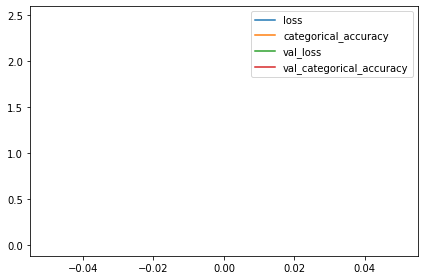

In [47]:
history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), batch_size=32, epochs=1, callbacks=[model_checkpoint_callback])

show_history(history)

# Load best setup
model.load_weights("weights.best.hdf5")
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc)

# Fine-tuning
* Once your model has converged on the new data, you can try to unfreeze all or part of the base model and retrain the whole model end-to-end with a very low learning rate.
* It could also potentially lead to quick overfitting -- keep that in mind.
* It is critical to only do this step **after the model with frozen layers has been trained to convergence**. 
    * If you mix randomly-initialized trainable layers with trainable layers that hold pre-trained features, the randomly-initialized layers will cause very large gradient updates during training, which will **destroy your pre-trained features**.
    
### It's also critical to use a very low learning rate at this stage, because you are training a much larger model than in the first round of training, on a dataset that is typically very small. 
* As a result, you are at **risk of overfitting** very quickly if you apply large weight updates.

## Unfreeze the base model

In [14]:
base_model.trainable = True

## Recompile your model after you make any changes
* So the `trainable` attribute of any inner layer is taken into account

### Calling compile() on a model is meant to "freeze" the behavior of that model. 
* This implies that the trainable attribute values at the time the model is compiled should be preserved throughout the lifetime of that model, until compile is called again. 
* Hence, if you change any trainable value, make sure to call compile() again on your model for your changes to be taken into account.

In [15]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [16]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

25/25 [==============================] - 66s 515ms/step - loss: 2.3435 - categorical_accuracy: 0.0838 - val_loss: 2.2849 - val_categorical_accuracy: 0.1500


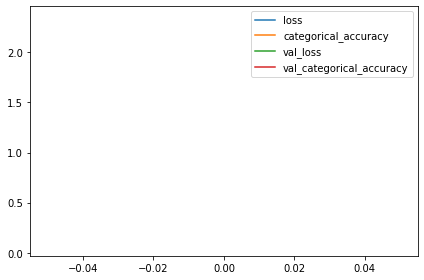

In [17]:
history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), batch_size=32, epochs=1, callbacks=[model_checkpoint_callback])

show_history(history)

# Load best setup
# model.load_weights("weights.best.hdf5")
# test_loss, test_acc = model.evaluate(test_x, test_y)
# print('Test accuracy: ', test_acc)

# Now, when you are an absolute expert on CNN applications in the image classification tasks 👏 we can switch to time series processing part of the lecture! 🙂

## 🔎What use - cases or tasks can you imagine for time series processing?

# We will use CNN again, but now in Conv1D variant
* What is the difference among the 1 - 3D Conv?

## There is definitely a cool mathematical expression for every conv type however I would like you to understand the topic so we will take a look at these diagrams 🙂

![Meme02](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_meme_tf_02.png?raw=true)

### Conv2D
* Conv2D is generally used on Image data. It is called 2 dimensional CNN because the kernel slides along 2 dimensions on the data as shown in the following image.

![Conv2D](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_04_conv2d.png?raw=true)


### Conv1D
* Following plot illustrate how the kernel will move on accelerometer data. Each row represents time series acceleration for some axis. The kernel can only move in one dimension along the axis of time.

![Conv1D](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_04_conv1d.png?raw=true)

## Summary
* In 1D CNN, kernel moves in 1 direction. Input and output data of 1D CNN is 2 dimensional. Mostly used on Time-Series data.
* In 2D CNN, kernel moves in 2 directions. Input and output data of 2D CNN is 3 dimensional. Mostly used on Image data.
* In 3D CNN, kernel moves in 3 directions. Input and output data of 3D CNN is 4 dimensional. Mostly used on 3D Image data (MRI, CT Scans, Video).
* You can see https://towardsdatascience.com/understanding-1d-and-3d-convolution-neural-network-keras-9d8f76e29610 for more details

# Download the FordA data

* Let's download [FordA](https://www.timeseriesclassification.com/description.php?Dataset=FordA) dataset converted for our purposes to the [Feather file format](https://arrow.apache.org/docs/python/feather.html), a binary file format for data exchange.

* The data originates from ARFF file format used in Weka Data analysis tool and has classes labeled $\{-1,1\}$ 
    * It is not suitable for TensorFlow (SKLearn has no trouble with it), so we have to convert it to the $\{0,1\}$ set

In [18]:
train = pd.read_feather('https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/raw/main/datasets/FordA_TRAIN.feather')
test = pd.read_feather('https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/raw/main/datasets/FordA_TEST.feather')
train.target.replace({-1:0}, inplace=True)
test.target.replace({-1:0}, inplace=True)
print('Train: ',train.shape)
print('Test: ', test.shape)

Train:  (3601, 501)
Test:  (1320, 501)


## We can take a look at the data
* The data contain 500 time steps of a measurement and single target value. 
* The time series is almost normalized and it is not necessary to deal with it using scaling or normalizing. 
    * It may slightly improve the results but it depends on your experiments. 

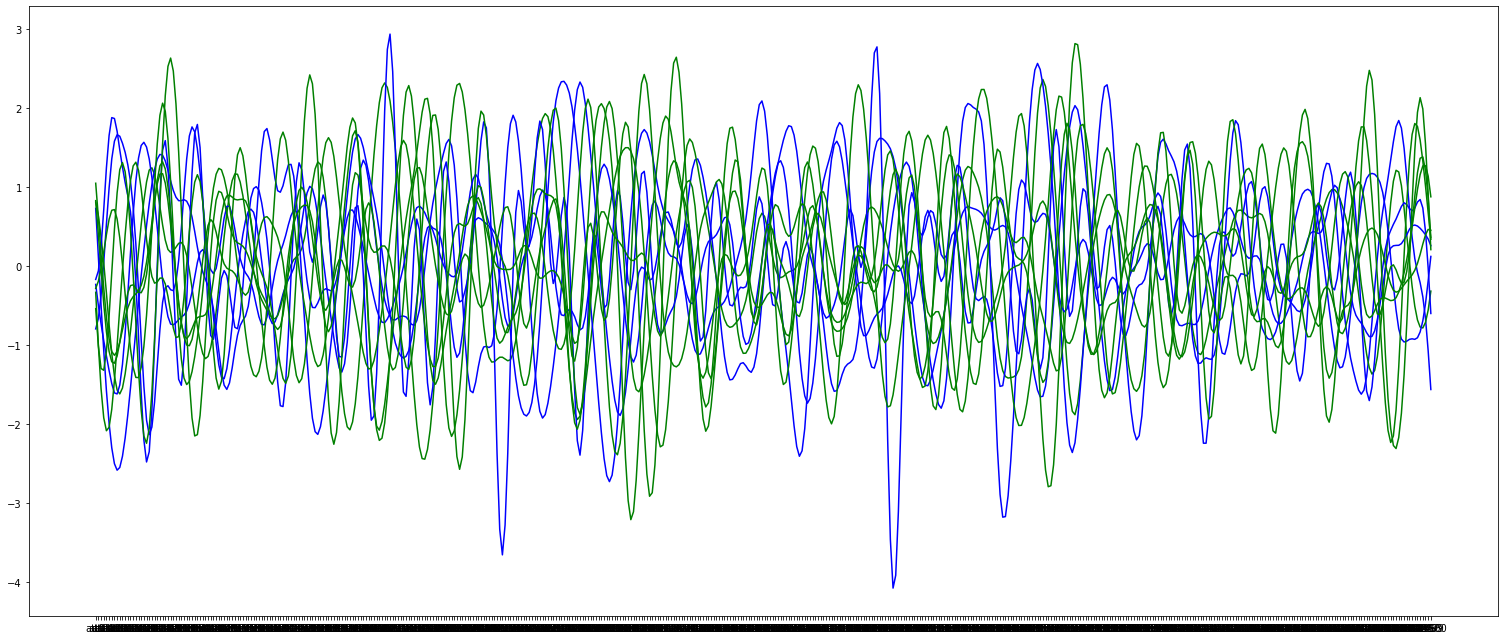

In [19]:
colors = ['b', 'g']
plt.figure(figsize=(21,9))
for idx in range(10):
  plt.plot(train.iloc[idx][:-1], c=colors[int(train.iloc[idx][-1])])
plt.tight_layout()
plt.show()

In [20]:
train.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att492,att493,att494,att495,att496,att497,att498,att499,att500,target
0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,1.640809,...,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343,0
1,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,-1.619951,...,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086,1
2,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,-2.550600,...,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391,0
3,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,-1.506933,...,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736,0
4,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,1.466467,...,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213,0


In [21]:
train.groupby('target').mean()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att491,att492,att493,att494,att495,att496,att497,att498,att499,att500
target,,,,,,,,,,,,,,,,,,,,,
0,-0.014895,-0.015515,-0.016355,-0.016704,-0.015422,-0.011477,-0.006306,-0.001435,0.002810,0.004730,...,0.020576,0.014972,0.006110,-0.003215,-0.010949,-0.014388,-0.012541,-0.006267,0.002245,0.010434
1,-0.018616,-0.015013,-0.010712,-0.006936,-0.004227,-0.002419,-0.000538,0.002675,0.008029,0.015609,...,-0.003742,-0.001601,0.001889,0.005288,0.007573,0.008220,0.006549,0.002857,-0.002297,-0.008113


In [22]:
train.groupby('target').std()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att491,att492,att493,att494,att495,att496,att497,att498,att499,att500
target,,,,,,,,,,,,,,,,,,,,,
0,1.046503,1.038535,1.030145,1.031180,1.041815,1.051984,1.053741,1.048960,1.042726,1.03680,...,1.037209,1.037731,1.034531,1.025603,1.011854,0.997298,0.987655,0.990511,1.007039,1.028501
1,1.071179,1.066081,1.059798,1.054695,1.052556,1.053998,1.057515,1.060192,1.058752,1.05203,...,1.038403,1.043903,1.047698,1.048433,1.045641,1.040933,1.036925,1.035120,1.035589,1.036879


## Check the labels balance
* Which metrics can we use? Why?

In [23]:
train.target.value_counts()

0    1846
1    1755
Name: target, dtype: int64

### Convert the data into numpy arrays and separates *X* and *y* data from each other for training and testing data.

In [24]:
train_x, train_y = train.drop(columns=['target']).values, train.target.values
test_x, test_y = test.drop(columns=['target']).values, test.target.values

## Create a baseline model
* Lets try some simple basic model on the data. DecisionTree and RandomForrest. As you will see it is a difficult task for them to get nice results.

In [25]:
base_models = [DecisionTreeClassifier(random_state=13), RandomForestClassifier(random_state=13)]

for model in base_models:
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    print(type(model).__name__)
    compute_metrics(test_y, y_pred)

DecisionTreeClassifier
	Accuracy:    56.36%
RandomForestClassifier
	Accuracy:    73.18%


## Fully connected ANN model
* Let's try some basic neural network model for this task. 
* The first is a classical Dense network with two hidden layers and dropout optimization, that is able to beat the Randomforrest classifier.

In [26]:
model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=train_x[0].shape),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()
model.compile(optimizer=keras.optimizers.Adam(), loss = keras.losses.BinaryCrossentropy(from_logits=False), metrics = keras.metrics.BinaryAccuracy())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 256)               128256    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                16448     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 210,561
Trainable params: 210,561
Non-trai

In [27]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/10
113/113 [==============================] - 2s 7ms/step - loss: 0.6307 - binary_accuracy: 0.6432 - val_loss: 0.5700 - val_binary_accuracy: 0.7023
Epoch 2/10
113/113 [==============================] - 1s 5ms/step - loss: 0.5191 - binary_accuracy: 0.7470 - val_loss: 0.5434 - val_binary_accuracy: 0.7250
Epoch 3/10
113/113 [==============================] - 1s 5ms/step - loss: 0.4658 - binary_accuracy: 0.7820 - val_loss: 0.5547 - val_binary_accuracy: 0.7189
Epoch 4/10
113/113 [==============================] - 1s 5ms/step - loss: 0.3966 - binary_accuracy: 0.8234 - val_loss: 0.5236 - val_binary_accuracy: 0.7561
Epoch 5/10
113/113 [==============================] - 1s 5ms/step - loss: 0.3604 - binary_accuracy: 0.8425 - val_loss: 0.5119 - val_binary_accuracy: 0.7735
Epoch 6/10
113/113 [==============================] - 1s 5ms/step - loss: 0.3113 - binary_accuracy: 0.8678 - val_loss: 0.4984 - val_binary_accuracy: 0.7765
Epoch 7/10
113/113 [==============================] - 1s 5ms/ste

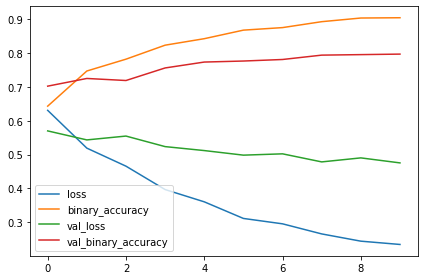

In [28]:
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=10, batch_size=32, callbacks=[model_checkpoint_callback])
show_history(history)

model.load_weights("weights.best.hdf5")
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc)

## Now we will finally use the CNN! 🙂
* To use convolution in single dimension we need to reshape the data to have the proper format. 
* The format is the same to recurrent ANN models (accidentaly) and must be in a format $(number\_of\_vectors, vector\_length,number\_of\_dimensions)$.

In [29]:
train_xc = np.reshape(train_x, (*train_x.shape, 1))
test_xc = np.reshape(test_x, (*test_x.shape, 1))
train_xc.shape, test_xc.shape

((3601, 500, 1), (1320, 500, 1))

### Let's try the single convolution layer as a input mapping that generates a huge number of weights for Dense layers after flattening. 

* The results are not excelent. 
* Why?

In [30]:
model = keras.Sequential([
    keras.layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=train_xc[0].shape),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()
model.compile(optimizer=keras.optimizers.Adam(), loss = keras.losses.BinaryCrossentropy(from_logits=False), metrics = keras.metrics.BinaryAccuracy())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 498, 64)           256       
                                                                 
 flatten (Flatten)           (None, 31872)             0         
                                                                 
 dense_5 (Dense)             (None, 64)                2039872   
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,040,193
Trainable params: 2,040,193
Non-trainable params: 0
_________________________________________________________________


In [31]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/10
113/113 [==============================] - 2s 7ms/step - loss: 0.6809 - binary_accuracy: 0.5834 - val_loss: 0.6255 - val_binary_accuracy: 0.6659
Epoch 2/10
113/113 [==============================] - 1s 6ms/step - loss: 0.5750 - binary_accuracy: 0.7104 - val_loss: 0.5889 - val_binary_accuracy: 0.6939
Epoch 3/10
113/113 [==============================] - 1s 5ms/step - loss: 0.5073 - binary_accuracy: 0.7520 - val_loss: 0.5770 - val_binary_accuracy: 0.7152
Epoch 4/10
113/113 [==============================] - 1s 5ms/step - loss: 0.4482 - binary_accuracy: 0.7948 - val_loss: 0.5490 - val_binary_accuracy: 0.7371
Epoch 5/10
113/113 [==============================] - 1s 5ms/step - loss: 0.3807 - binary_accuracy: 0.8417 - val_loss: 0.5470 - val_binary_accuracy: 0.7492
Epoch 6/10
113/113 [==============================] - 1s 5ms/step - loss: 0.3287 - binary_accuracy: 0.8611 - val_loss: 0.5531 - val_binary_accuracy: 0.7364
Epoch 7/10
113/113 [==============================] - 1s 5ms/ste

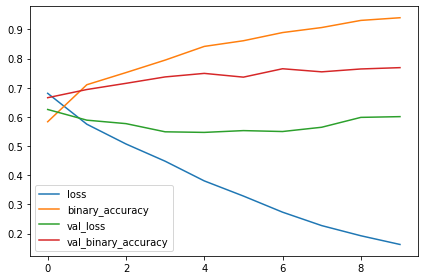

In [32]:
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=10, batch_size=32, callbacks=[model_checkpoint_callback])
show_history(history)

model.load_weights("weights.best.hdf5")
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc)

### The slightly more complicated model is able to beat all previous models with smallel number of weight needed.

In [33]:
model = keras.Sequential([
    keras.layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=train_xc[0].shape),
    keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    keras.layers.MaxPool1D(2),
    keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()
model.compile(optimizer=keras.optimizers.Adam(), loss = keras.losses.BinaryCrossentropy(from_logits=False), metrics = keras.metrics.BinaryAccuracy())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 498, 64)           256       
                                                                 
 conv1d_2 (Conv1D)           (None, 496, 64)           12352     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 248, 64)          0         
 )                                                               
                                                                 
 conv1d_3 (Conv1D)           (None, 246, 64)           12352     
                                                                 
 conv1d_4 (Conv1D)           (None, 244, 64)           12352     
                                                                 
 flatten_1 (Flatten)         (None, 15616)             0         
                                                      

In [34]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/10
113/113 [==============================] - 5s 17ms/step - loss: 0.6504 - binary_accuracy: 0.5746 - val_loss: 0.5554 - val_binary_accuracy: 0.6795
Epoch 2/10
113/113 [==============================] - 1s 8ms/step - loss: 0.3855 - binary_accuracy: 0.8234 - val_loss: 0.2765 - val_binary_accuracy: 0.8871
Epoch 3/10
113/113 [==============================] - 1s 8ms/step - loss: 0.2832 - binary_accuracy: 0.8756 - val_loss: 0.2483 - val_binary_accuracy: 0.9015
Epoch 4/10
113/113 [==============================] - 1s 7ms/step - loss: 0.2025 - binary_accuracy: 0.9186 - val_loss: 0.2764 - val_binary_accuracy: 0.8894
Epoch 5/10
113/113 [==============================] - 1s 8ms/step - loss: 0.1508 - binary_accuracy: 0.9431 - val_loss: 0.2569 - val_binary_accuracy: 0.9038
Epoch 6/10
113/113 [==============================] - 1s 7ms/step - loss: 0.1084 - binary_accuracy: 0.9586 - val_loss: 0.3114 - val_binary_accuracy: 0.8955
Epoch 7/10
113/113 [==============================] - 1s 8ms/st

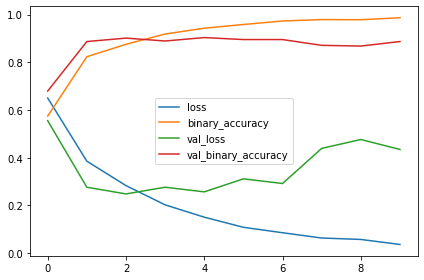

In [35]:
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=10, batch_size=32, callbacks=[model_checkpoint_callback])
show_history(history)

model.load_weights("weights.best.hdf5")
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc)

### Even more capable model with more pooling layers with 1/4 weight of the previsou model is able to achieve more than 90% of the accuracy. 

In [36]:
model = keras.Sequential([
    keras.layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=train_xc[0].shape),
    keras.layers.MaxPool1D(2),
    keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    keras.layers.MaxPool1D(2),
    keras.layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=train_xc[0].shape),
    keras.layers.MaxPool1D(2),
    keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()
model.compile(optimizer=keras.optimizers.Adam(), loss = keras.losses.BinaryCrossentropy(from_logits=False), metrics = keras.metrics.BinaryAccuracy())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 498, 64)           256       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 249, 64)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 247, 64)           12352     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 123, 64)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 121, 64)           12352     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 60, 64)          

In [37]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/10
113/113 [==============================] - 7s 16ms/step - loss: 0.6043 - binary_accuracy: 0.6220 - val_loss: 0.5180 - val_binary_accuracy: 0.6886
Epoch 2/10
113/113 [==============================] - 1s 8ms/step - loss: 0.3387 - binary_accuracy: 0.8467 - val_loss: 0.2974 - val_binary_accuracy: 0.8727
Epoch 3/10
113/113 [==============================] - 1s 7ms/step - loss: 0.2577 - binary_accuracy: 0.8892 - val_loss: 0.2986 - val_binary_accuracy: 0.8826
Epoch 4/10
113/113 [==============================] - 1s 8ms/step - loss: 0.2388 - binary_accuracy: 0.8942 - val_loss: 0.3989 - val_binary_accuracy: 0.8318
Epoch 5/10
113/113 [==============================] - 1s 7ms/step - loss: 0.1867 - binary_accuracy: 0.9259 - val_loss: 0.2633 - val_binary_accuracy: 0.8970
Epoch 6/10
113/113 [==============================] - 1s 8ms/step - loss: 0.1601 - binary_accuracy: 0.9361 - val_loss: 0.3611 - val_binary_accuracy: 0.8636
Epoch 7/10
113/113 [==============================] - 1s 7ms/st

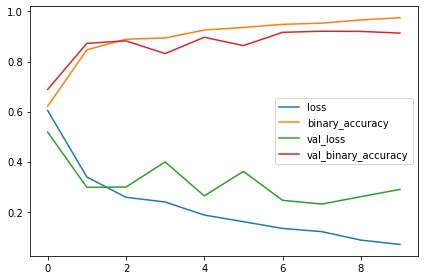

In [38]:
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=10, batch_size=32, callbacks=[model_checkpoint_callback])
show_history(history)

model.load_weights("weights.best.hdf5")
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc)

## Tasks for the lecture (2p)

1) Choose any of the models from [Keras pre-trained models](https://keras.io/api/applications/) - **(1p)**

    * Investigate its' architecture
    * Search for the needed input shape for the model
        * There could be more variants of the model, choice depends on you
    * Use the model for CIFAR-10 classification, fine-tune it, experiment with it and write down your conclusions!
    
2) Define your own model for the FordA data task  - **(1p)**

    * Try to beat our models or have at least equal accuracy
        * You can also try to minimize the number of parameters for having approx. the same accuracy as we do!
    * Experiment with the model and write down your conclusions!

In [39]:
dataset = tf.keras.datasets.cifar10
img_size = 224
subset = 1000

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_count = len(class_names)

# data from any dataset are loaded using the load_Data function
(train_x, train_y), (test_x, test_y) = dataset.load_data()

train_y = tf.keras.utils.to_categorical(train_y[:subset], class_count)
test_y = tf.keras.utils.to_categorical(test_y[:subset], class_count)

rs_train_x = resize(train_x[:subset], (len(train_x[:subset]),img_size,img_size,3), preserve_range=True).astype(np.uint8)

del train_x

rs_test_x = resize(test_x[:subset], (len(test_x[:subset]),img_size,img_size,3), preserve_range=True).astype(np.uint8)

del test_x

rs_train_x = rs_train_x/255.0
rs_test_x = rs_test_x/255.0

train_x, valid_x, train_y, valid_y = train_test_split(rs_train_x, train_y, test_size=0.2, random_state=42)
test_x = rs_test_x


In [49]:
def test_classifier(classifier):
    base_model = classifier(
        include_top=False,
        weights="imagenet",
        input_shape=(img_size, img_size, 3),
        )
    
    base_model.trainable = False
    
    inputs = keras.Input(shape=(img_size, img_size, 3))
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(class_count, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss=keras.losses.CategoricalCrossentropy(),
                  metrics=[keras.metrics.CategoricalAccuracy()])
    
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='weights.best.hdf5',
        save_weights_only=True,
        monitor='val_loss',
        mode='auto',
        save_best_only=True)
    
    history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), batch_size=32, epochs=10, callbacks=[model_checkpoint_callback], verbose=0)
    
    show_history(history)
    
    model.load_weights('weights.best.hdf5')
    test_loss, test_acc = model.evaluate(test_x, test_y)
    print(f'Test accuracy: {test_acc:.3f}')

    base_model.trainable = True
    
    model.compile(optimizer=keras.optimizers.Adam(1e-5),
                  loss=keras.losses.CategoricalCrossentropy(),
                  metrics=[keras.metrics.CategoricalAccuracy()])
    
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='weights.best.hdf5',
        save_weights_only=True,
        monitor='val_loss',
        mode='auto',
        save_best_only=True)
    
    history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), batch_size=32, epochs=3, callbacks=[model_checkpoint_callback], verbose=0)
    
    show_history(history)
    
    model.load_weights('weights.best.hdf5')
    test_loss, test_acc = model.evaluate(test_x, test_y)
    print(f'Test accuracy: {test_acc:.3f}')

32/32 [==============================] - 3s 87ms/step - loss: 2.3101 - categorical_accuracy: 0.1040
Test accuracy: 0.104
32/32 [==============================] - 3s 86ms/step - loss: 2.3026 - categorical_accuracy: 0.0890
Test accuracy: 0.089


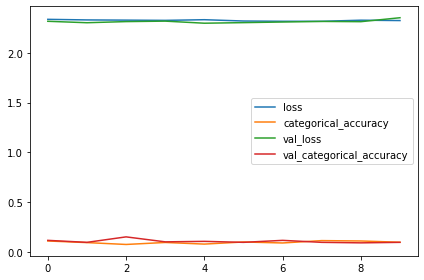

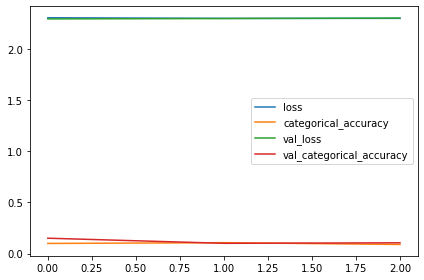

In [50]:
from tensorflow.keras.applications import EfficientNetB2
    
test_classifier(EfficientNetB2)

32/32 [==============================] - 7s 217ms/step - loss: 0.6314 - categorical_accuracy: 0.7840
Test accuracy: 0.784
32/32 [==============================] - 7s 212ms/step - loss: 0.5867 - categorical_accuracy: 0.8450
Test accuracy: 0.845


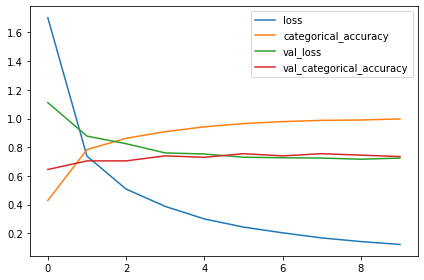

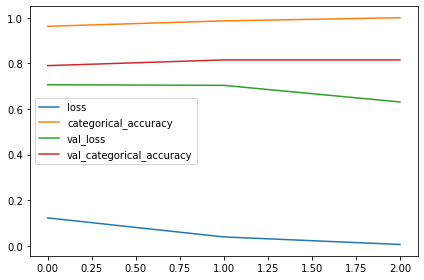

In [51]:
from tensorflow.keras.applications import ResNet152V2

test_classifier(ResNet152V2)

The performance of the EfficientNet network was rather underwhelming, though there might be a problem in my utilization of the network.

A larger ResNet network performed better than the smaller ResNet network.

Using Max Pooling instead of Average Pooling caused the network to perform notably worse.

Fine-tuning and training the entire model worsened the performance of EfficientNet, but increased the performance of ResNet.

In [52]:
train = pd.read_feather('https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/raw/main/datasets/FordA_TRAIN.feather')
test = pd.read_feather('https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/raw/main/datasets/FordA_TEST.feather')
train.target.replace({-1:0}, inplace=True)
test.target.replace({-1:0}, inplace=True)

train_x, train_y = train.drop(columns=['target']).values, train.target.values
test_x, test_y = test.drop(columns=['target']).values, test.target.values

train_xc = np.reshape(train_x, (*train_x.shape, 1))
test_xc = np.reshape(test_x, (*test_x.shape, 1))

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_30 (Conv1D)          (None, 498, 64)           256       
                                                                 
 max_pooling1d_25 (MaxPoolin  (None, 249, 64)          0         
 g1D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 249, 64)           0         
                                                                 
 conv1d_31 (Conv1D)          (None, 247, 64)           12352     
                                                                 
 max_pooling1d_26 (MaxPoolin  (None, 123, 64)          0         
 g1D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 123, 64)         

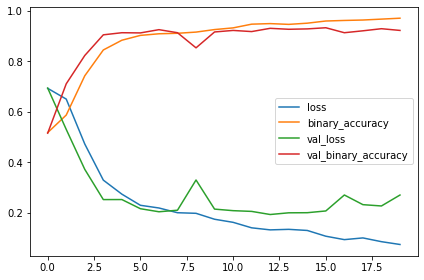

In [60]:
model = keras.Sequential([
    keras.layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=train_xc[0].shape),
    keras.layers.MaxPool1D(2),
    keras.layers.Dropout(0.2),
    keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    keras.layers.MaxPool1D(2),
    keras.layers.Dropout(0.2),
    keras.layers.Conv1D(32, kernel_size=3, activation='relu'),
    keras.layers.MaxPool1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=keras.metrics.BinaryAccuracy(),
    )

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=20, batch_size=32, callbacks=[model_checkpoint_callback], verbose=0)
show_history(history)

model.load_weights("weights.best.hdf5")
test_loss, test_acc = model.evaluate(test_x, test_y)
print(f'Test accuracy: {test_acc:.3f}')


By dropping one conv layer, decreasing the number of convolutions in the last conv layer, by using a smaller FC network, and by applying dropout, I was able to create a model
which performs slightly better at one third the parameters of the original network.

Increasing the size of the convolution mask in the first layer didn't make the network any
better.